## Variational Inference: Ising Model

This notebook focuses on Variational Inference (VI) for the Ising model in application to binary image de-noising. The Ising model is an example of a Markov Random Field (MRF) and it originated from statistical physics. The Ising model assumes that we have a grid of nodes, where each node can be in one of two states. In the case of binary images, you can think of each node as being a pixel with a black or white color. The state of each node depends on the neighboring nodes through interaction potentials. In the case of images, this translates to a smoothness constraint, i.e. a pixel prefers to be of the same color as the neighboring pixels. In the image denoising problem, we assume that we have a 2-D grid of noisy pixel observations of an underlying true image and we would like to recover the true image. Thus, we can model the image as a grid:

<img src="figures/ising_gm.png">

In the figure above, the shaded nodes are the noisy observations $y_i$ of binary latent variables $x_i \in \{-1, +1\}$. We can write down the joint distribution as follows:

\begin{equation}
    p(x,y) = p(x)p(y|x) = \prod_{(s,t)\in E} \Psi_{st}(x_s, x_t) \prod_{i=1}^{n}p(y_i|x_i) = \prod_{(s,t)\in E} \exp \{x_s w_{st} x_t \} \prod_{i=1}^{N} N(y_i|x_i, \sigma^2)
\end{equation}

where the interaction potentials are represented by $\Psi_{st}$ for every pair of nodes $x_s$ and $x_t$ in a set of edges $E$ and the observations $y_i$ are Gaussian with mean $x_i$ and variance $\sigma^2$. Here, $w_{st}$ is the coupling strength and assumed to be constant and equal to $J>0$ indicating a preference for the same state as neighbors (i.e. potential $\Psi(x_s, x_t) = \exp\{x_s J x_t\}$ is higher when $x_s$ and $x_t$ are both either $+1$ or $-1$).

The basic idea behind variational inference is to choose an approximating disribution $q(x)$ which is close to the original distribution $p(x)$ where the distance is measured by KL divergence:

\begin{equation}
    KL(q||p) = \sum_x q(x) \log \frac{q(x)}{p(x)}
\end{equation}

This makes inference into an optimization problem in which the objective is to minimize KL divergence or maximize the Evidence Lower BOund (ELBO). We can derive the ELBO as follows:

\begin{equation}
    \log p(y) = \log \sum_{x} p(x,y) = \log \sum_x \frac{q(x)}{q(x)}p(x,y) = \log E_{q(x)}\big[\frac{p(x,y)}{q(x)} \big] \geq E_{q(x)}\big[\log \frac{p(x,y)}{q(x)} \big] = E_{q(x)}\big[\log p(x,y) \big] - E_{q(x)}\big[\log q(x) \big]
\end{equation}

In application to the Ising model, we have:

\begin{equation}
    \mathrm{ELBO} = E_{q(x)}\big[\log p(x,y) \big] - E_{q(x)}\big[\log q(x) \big] = E_{q(x)}\big[\sum_{(s,t)\in E}x_s w_{st}x_t + \sum_{i=1}^{n} \log N(x_i, \sigma^2) \big] - \sum_{i=1}^{n} E_{q_i(x)}\big[\log q_i(x) \big]
\end{equation}

In *mean-field* variational inference, we assume a *fully-factored* approximation q(x):

\begin{equation}
    q(x) = \prod_{i=1}^{n} q(x_i; \mu_i)
\end{equation}

It can be shown [1] that $q(x_i;\mu_i)$ that minimizes the KL divergence is given by:

\begin{equation}
    q_i(x_i) = \frac{1}{Z_i}\exp \big[E_{-q_i}\{\log p(x) \} \big]
\end{equation}

where $E_{-q_i}$ denotes an expectation over every $q_j$ except for $j=i$. To compute $q_i(x_i)$, we only care about the terms that involve $x_i$, i.e. we can isolate them as follows:

\begin{equation}
    E_{-q_i}\{\log p(x)\} = E_{-q_i}\{x_i \sum_{j\in N(i)} w_{ij}x_j + \log N(x_i,\sigma^2) + \mathrm{const} \} = x_i \sum_{j\in N(i)}J\times \mu_j + \log N(x_i, \sigma^2) + \mathrm{const}
\end{equation}

where $N(i)$ denotes the neighbors of node $i$ and $\mu_j$ is the mean of a binary random variable:

\begin{equation}
    \mu_j = E_{q_j}[x_j] = q_j(x_j=+1)\times (+1) + q_j(x_j=-1)\times (-1)
\end{equation}

In order to compute this mean, we need to know the values of $q_j(x_j=+1)$ and $q_j(x_j=-1)$. Let $m_i = \sum_{j\in N(i)} w_{ij}\mu_j$ be the mean value of neighbors and let $L_{i}^{+} = N(x_i=+1; \sigma^2)$ and $L_{i}^{-} = N(x_i=-1; \sigma^2)$, then we can compute the mean as follows:

\begin{equation}
    q_i(x_i=+1) = \frac{\exp\{m_i + L_{i}^{+}\}}{\exp\{m_i + L_{i}^{+}\} + \exp\{-m_i + L_{i}^{-}\}} = \frac{1}{1+\exp\{-2m_i+L_{i}^{-}-L_{i}^{+}\}} = \frac{1}{1+\exp\{-2 a_i\}} = \sigma(2a_i)
\end{equation}

\begin{equation}
    q_i(x_i=-1) = 1 - q_i(x_i=+1) = 1 - \sigma(2a_i) = \sigma(-2a_i)
\end{equation}

\begin{equation}
    \mu_i = E_{q_i}[x_i] = \sigma(2a_i) - \sigma(-2a_i) = \tanh(a_i)
\end{equation}

where $a_i = m_i + 1/2\big(L_{i}^{+} - L_{i}^{-}\big)$. In other words, our mean-field variational updates of the parameters $\mu_i$ at iteration $k$ are computed as follows:

\begin{equation}
    \mu_{i}^{(k)} = \tanh \bigg(\sum_{j\in N(i)}w_{ij}\mu_{j}^{(k-1)} + \frac{1}{2}\bigg[\log \frac{N(x_i=+1, \sigma^2)}{N(x_i=-1, \sigma^2)} \bigg] \bigg) \times \lambda + (1-\lambda)\times \mu_{i}^{(k-1)}
    \end{equation}

where we added a learning rate parameter $\lambda$. The figure below shows the parametric form of our mean-field approximation of the Ising model:

<img src="figures/ising_vi2.png">

Now that we derived the variational updates and the ELBO, let's implement this in Python in application to binary image denoising!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

np.random.seed(0)
sns.set_style('whitegrid')

Let's load a grayscale (single channel) image, add Gaussian noise and binarize it based on mean threshold. We can then define variational inference parameters such as the coupling strength, noise level, smoothing rate and max number of iterations:

In [4]:
#load data
print("loading data...")
data = Image.open('bayes.bmp')
img = np.double(data)
img_mean = np.mean(img)
img_binary = +1*(img>img_mean) + -1*(img<img_mean)
[M, N] = img_binary.shape

#mean-field parameters
sigma  = 2  #noise level
y = img_binary + sigma*np.random.randn(M, N) #y_i ~ N(x_i; sigma^2);
J = 1  #coupling strength (w_ij)
rate = 0.5  #update smoothing rate
max_iter = 15
ELBO = np.zeros(max_iter)
Hx_mean = np.zeros(max_iter)


loading data...


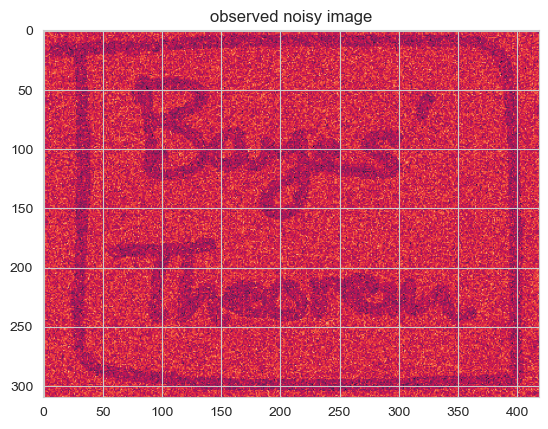

In [6]:
#generate plots
plt.figure()
plt.imshow(y)
plt.title("observed noisy image")
plt.savefig('ising_vi_observed_image.png')

We can now run variational inference for the Ising model:

In [14]:
logodds.shape

(310, 419)

In [8]:
#Mean-Field VI
print("running mean-field variational inference...")
logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

#init
p1 = sigmoid(logodds)
mu = 2*p1-1  #mu_init

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    muNew = mu
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])            
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            
            Sbar = J*np.sum(mu[nx,ny])       
            muNew[xx,yy] = (1-rate)*muNew[xx,yy] + rate*np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])
        #end for
    #end for
    mu = muNew
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx)            
#end for

running mean-field variational inference...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:56<00:00,  3.80s/it]


Let's plot the mean parameters $\mu_i$ for every pixel to see how well we de-noised the image:

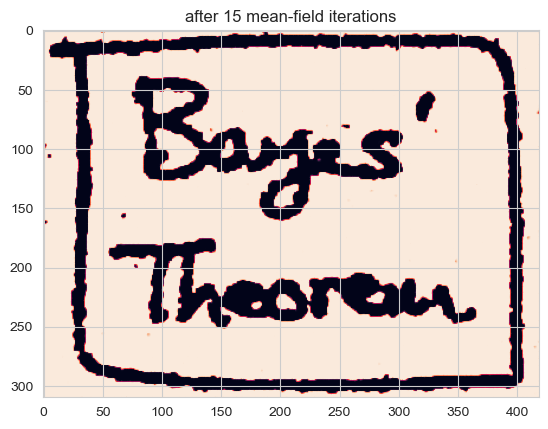

In [10]:
plt.figure()
plt.imshow(mu)
plt.title("after %d mean-field iterations" %max_iter)
plt.savefig('ising_vi_denoised_image.png')

Not bad! By setting a positive coupling strength $w_{ij} = J > 0$, we were able to find the mean parameters for our approximating distribution $q_i(x_i)$ that maximized the ELBO objective and resulted in mostly denoised image. We can visualize the ELBO objective as a function of iterations as follows:

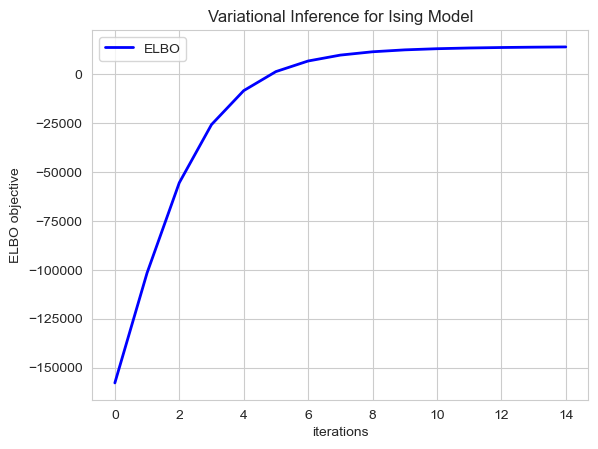

In [11]:
plt.figure()
plt.plot(ELBO, color='b', lw=2.0, label='ELBO')
plt.title('Variational Inference for Ising Model')
plt.xlabel('iterations'); plt.ylabel('ELBO objective')
plt.legend(loc='upper left')
plt.savefig('ising_vi_elbo.png')

Notice that the ELBO is monotonically increasing and flattening out after about 10 iterations. To get further insight into de-noising, we can plot the average entropy $\frac{1}{n}\sum_{i=1}^{n}H_q(x_i)$. We expect early entropy to be high due to random initialization, however, as the number of iterations increases, mean-field updates converge on binary values of $x_i$ that are consistent with observations and the neighbors resulting in a decrease in average entropy:

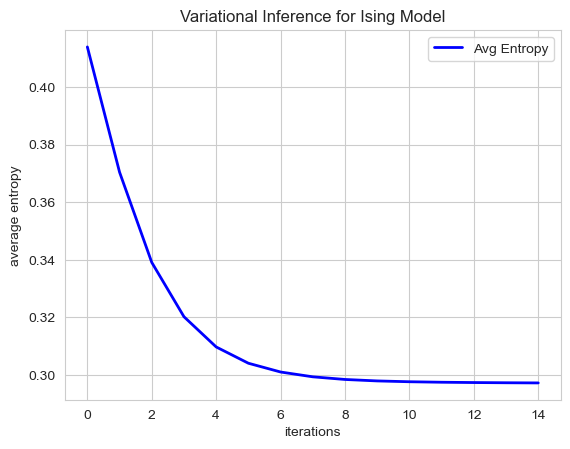

In [12]:
plt.figure()
plt.plot(Hx_mean, color='b', lw=2.0, label='Avg Entropy')
plt.title('Variational Inference for Ising Model')
plt.xlabel('iterations'); plt.ylabel('average entropy')
plt.legend(loc="upper right")
plt.savefig('ising_vi_avg_entropy.png')

The 2-D Ising model can be extended in multiple ways, for example: 3-D grids and K-states per node (aka Potts model).

### References

[1] K. Murphy, "Machine Learning: A Probabilistic Perspective", The MIT Press, 2012  
[2] E. Sudderth, "CS242: Probabilistic Graphical Models", http://cs.brown.edu/courses/cs242/lectures/  

